In [ ]:
# Paper : "Score-based Generative Modeling through Stochastic Differential Equations" by Yang Song et al. (2021)
# The code below was written with reference to the paper's official open source code.
# Github Repository : https://github.com/yang-song/score_sde

# Import libraries

In [1]:
import os
import random
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
from tqdm.auto import tqdm
import gc
import json
import math

# Model

In [2]:
class GaussianFourierProjection(nn.Module):
    """
    Gaussian Fourier embeddings for continuous noise levels.

    Parameters:
        embedding_size (int) : Size of embedding
        scale (float) : Scaling factor
    """
    def __init__(self, embedding_size, scale=1.0):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embedding_size) * scale, requires_grad=False)

    def forward(self, x):
        """
        Parameters:
            x (torch.Tensor) : Input data. Get timestep t from [0,1]

        Returns:
            torch.Tensor : Gaussian Fourier embeddings

        Example:
            >>> embedding_size = 64
            >>> scale = 1.0
            >>> fourier = GaussianFourierProjection(embedding_size, scale)
            >>> t = torch.randn(64)
            >>> out = fourier(t)
            >>> print(out.shape) # torch.Size([64,128])
        """
        x_proj = x.unsqueeze(1) * self.W.unsqueeze(0) * 2 * math.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

def swish(x):
    # Activation function used in DDPM
    return x * torch.sigmoid(x)

class GroupNorm32(nn.GroupNorm):
    # GroupNorm 8 is used in the model instead of GroupNorm 32
    def __init__(self, num_channels, num_groups=8, eps=1e-6):
        super().__init__(num_groups, num_channels, eps=eps)

def conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True, init_scale=1.0):
    conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=bias)
    with torch.no_grad():
        conv.weight.data *= init_scale
    return conv

def nin(in_ch, out_ch, init_scale=1.0):
    # 1x1 convolution
    layer = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)
    with torch.no_grad():
        layer.weight.data *= init_scale
    return layer

def linear(in_features, out_features, init_scale=1.0):
    fc = nn.Linear(in_features, out_features)
    with torch.no_grad():
        fc.weight.data *= init_scale
    return fc

class DownsampleBlock(nn.Module):
    # Block that doubles down on resolution. Use convolution block or average pooling block.
    def __init__(self, channels, with_conv=True):
        super().__init__()
        if with_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        return self.op(x)

class UpsampleBlock(nn.Module):
    # Block that doubles the resolution. Use convolution block or interpolating block.
    def __init__(self, channels, with_conv=True):
        super().__init__()
        self.with_conv = with_conv
        if with_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0, mode='nearest')
        if self.with_conv:
            x = self.conv(x)
        return x

class ResnetBlock(nn.Module):
    """
    Resnet block used in DDPM. Use group normalization. Continuous timestep t is also received as input.

    Parameters:
        in_channels (int) : Number of input channels
        out_channels (int) : Number of Output channels
        temb_channels (int) : Number of time embedding channels
        dropout (float) : Dropout rate
        conv_shortcut (bool) : Whether to add convolution shortcut
    """
    def __init__(self, in_channels, out_channels=None,
                 temb_channels=512, dropout=0.0, conv_shortcut=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels if out_channels is not None else in_channels
        self.temb_channels = temb_channels
        self.dropout = dropout
        self.conv_shortcut = conv_shortcut

        self.norm1 = GroupNorm32(self.in_channels)
        self.conv1 = conv2d(self.in_channels, self.out_channels,
                            kernel_size=3, stride=1, padding=1, init_scale=1.0)
        self.temb_proj = linear(self.temb_channels, self.out_channels, init_scale=1.0)
        self.norm2 = GroupNorm32(self.out_channels)
        self.conv2 = conv2d(self.out_channels, self.out_channels,
                            kernel_size=3, stride=1, padding=1, init_scale=1.0)

        if self.in_channels != self.out_channels:
            if self.conv_shortcut:
                self.conv_shortcut = nn.Conv2d(self.in_channels, self.out_channels,
                                               kernel_size=3, stride=1, padding=1)
            else:
                self.conv_shortcut = nin(self.in_channels, self.out_channels)
        else:
            self.conv_shortcut = None

    def forward(self, x, temb):
        """
        Parameters:
            x (torch.Tensor) : Input data
            temb (torch.Tensor) : Embedding vector of timestep t

        Returns:
            torch.Tensor : Output data

        Example:
            >>> x = torch.randn(128,3,32,32)
            >>> temb = torch.randn(128,64)
            >>> block = ResnetBlock(in_channels=3,out_channels=32,temb_channels=64)
            >>> out = block(x,temb)
            >>> print(out.shape) # torch.Size([128,32,32,32])
        """
        h = self.norm1(x)
        h = swish(h) # B*3*32*32
        h = self.conv1(h) # B*32*32*32
        h_temb = swish(temb) # B*64
        h_temb = self.temb_proj(h_temb)  # B*32
        h_temb = h_temb[:, :, None, None]  # B*32*1*1
        h = h + h_temb
        h = self.norm2(h) # B*32*32*32
        h = swish(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.conv2(h) # B*32*32*32
        if self.conv_shortcut is not None:
            x = self.conv_shortcut(x) # B*32*32*32
        return x + h

class AttnBlock(nn.Module):
    """
    Attention block used in DDPM.

    Parameters:
        channels (int) : Number of input, output channels
    """
    def __init__(self, channels):
        super().__init__()
        self.norm = GroupNorm32(channels)
        self.q = nin(channels, channels)
        self.k = nin(channels, channels)
        self.v = nin(channels, channels)
        self.proj_out = nin(channels, channels, init_scale=0.0)

    def forward(self, x):
        """
        Parameters:
            x (torch.Tensor) : Input data

        Returns:
            torch.Tensor : Output data

        Example:
            >>> x = torch.randn(128,32,224,224)
            >>> block = AttnBlock(32)
            >>> out = block(x)
            >>> print(out.shape) # torch.Size([128,32,224,224])
        """
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h).permute(0, 2, 3, 1)  # (B, H, W, C)
        k = self.k(h).permute(0, 2, 3, 1)
        v = self.v(h).permute(0, 2, 3, 1)
        w = torch.einsum('bhwc,bHWc->bhwHW', q, k) * (C ** -0.5)
        w = w.reshape(B, H, W, H * W)
        w = F.softmax(w, dim=-1)
        w = w.reshape(B, H, W, H, W)
        h_ = torch.einsum('bhwHW,bHWc->bhwc', w, v)
        h_ = self.proj_out(h_.permute(0, 3, 1, 2))
        return x + h_

class DDPMModel(nn.Module):
    """
    Final DDPMModel. Modified version of UNet.
    Attention block is applied to where it is set to applied.
    Given noised data x_t and timestep t, the model estimates the value of noise at timestep t.
    This DDPM model is same as the one used in the DDPM paper except for the GaussianFourierProjection.
    Unlike origianl DDPM model, timestep t is set to [0,1] in this model.

    Parameters:
        in_channels (int) : Number of input channels
        out_channels (int) : Number of output channels
        ch (int) : Number of default channel
        ch_mult (tuple) : Coefficient multiblied by channels
        num_res_blocks (int) : Number of resnet blocks
        attn_resolutions (set) : Set of resolutions at which attention block applies
        dropout (float) : Dropout rate
        resamp_with_conv (bool) : Whether to use convolution while down(up)sampling
        init_resolution (int) : Resolution of input images
    """
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        ch=64,
        ch_mult=(1, 2, 2, 4),
        num_res_blocks=3,
        attn_resolutions={28,56},
        dropout=0.1,
        resamp_with_conv=True,
        init_resolution=224
    ):
        super().__init__()
        self.ch = ch
        self.ch_mult = ch_mult
        self.num_res_blocks = num_res_blocks
        self.attn_resolutions = attn_resolutions
        self.dropout = dropout
        self.num_levels = len(ch_mult)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.resamp_with_conv = resamp_with_conv
        self.init_resolution = init_resolution

        # Time Embedding
        self.fourier = GaussianFourierProjection(embedding_size=self.ch, scale=1.0)

        # Dimension of time embedding vector
        self.temb_ch = ch * 4

        # Timestep embedding layers
        self.temb_dense0 = linear(2*self.ch, self.temb_ch)
        self.temb_dense1 = linear(self.temb_ch, self.temb_ch)

        # Input conv
        self.conv_in = conv2d(in_channels, ch, kernel_size=3, stride=1, padding=1)

        # Downsample blocks
        # Each downsampling block(modulelist) is stored in down_blocks.
        # Each block is composed of resnetblocks and attention block(if needed).
        self.down_blocks = nn.ModuleList()
        curr_ch = ch
        curr_res = init_resolution
        for level in range(self.num_levels):
            level_blocks = nn.ModuleList()
            out_ch = ch * ch_mult[level]
            for i in range(num_res_blocks):
                level_blocks.append(ResnetBlock(curr_ch, out_ch, temb_channels=self.temb_ch, dropout=dropout))
                if curr_res in attn_resolutions:
                    level_blocks.append(AttnBlock(out_ch))
                curr_ch = out_ch
            self.down_blocks.append(level_blocks)
            if level != self.num_levels - 1:
                self.down_blocks.append(DownsampleBlock(curr_ch, with_conv=resamp_with_conv))
                curr_res //= 2

        # Middle blocks
        self.mid_block = nn.ModuleList([
            ResnetBlock(curr_ch, curr_ch, temb_channels=self.temb_ch, dropout=dropout),
            AttnBlock(curr_ch),
            ResnetBlock(curr_ch, curr_ch, temb_channels=self.temb_ch, dropout=dropout)
        ])

        # Upsample blocks
        # Symmetric structure with downsample blocks
        self.up_blocks = nn.ModuleList()
        for level in reversed(range(self.num_levels)):
            level_blocks = nn.ModuleList()
            out_ch = ch * ch_mult[level]
            level_blocks.append(ResnetBlock(curr_ch + out_ch, out_ch, temb_channels=self.temb_ch, dropout=dropout))
            if (init_resolution // (2 ** level)) in attn_resolutions:
                level_blocks.append(AttnBlock(out_ch))
            curr_ch = out_ch
            for i in range(num_res_blocks):
                level_blocks.append(ResnetBlock(curr_ch, curr_ch, temb_channels=self.temb_ch, dropout=dropout))
                if (init_resolution // (2 ** level)) in attn_resolutions:
                    level_blocks.append(AttnBlock(curr_ch))
            if level != 0:
                level_blocks.append(UpsampleBlock(curr_ch, with_conv=resamp_with_conv))
            self.up_blocks.append(level_blocks)

        # output conv
        self.norm_out = GroupNorm32(curr_ch)
        self.conv_out = conv2d(curr_ch, out_channels, kernel_size=3, stride=1, padding=1, init_scale=0.0)

    def forward(self, x, sigma):
        """
        Parameters:
            x (torch.Tensor) : Input data
            sigma (torch.Tensor) : Timesteps of batch data. Get continuous noise level sigma(t) from [0,1]

        Returns:
            torch.Tensor : Output data

        Example:
            x = torch.randn(128,3,32,32)
            t = torch.rand(128)
            model = DDPMModel(ch=64,attn_resolution={16},init_resolution=32)
            out = model(x,t)
            print(out.shape) # torch.Size([128,3,32,32])
        """
        # 1) Timestep embedding
        log_sigma = torch.log(sigma)
        temb = self.fourier(log_sigma) # B*2ch
        temb = self.temb_dense0(temb) # B*4ch
        temb = swish(temb)
        temb = self.temb_dense1(temb) # B*4ch

        # 2) Downsampling
        skips = []
        h = self.conv_in(x)
        down_iter = iter(self.down_blocks)
        for level in range(self.num_levels):
            blocks = next(down_iter)
            for layer in blocks:
                h = layer(h, temb) if isinstance(layer, ResnetBlock) else layer(h)
            skips.append(h)
            if level != self.num_levels - 1:
                downsample = next(down_iter)
                h = downsample(h)

        # 3) Middle
        for layer in self.mid_block:
            h = layer(h, temb) if isinstance(layer, ResnetBlock) else layer(h)

        # 4) Upsampling
        for level in range(self.num_levels):
            blocks = self.up_blocks[level]
            skip = skips.pop()
            h = torch.cat([h, skip], dim=1)
            h = blocks[0](h, temb)
            for layer in blocks[1:]:
                if isinstance(layer, ResnetBlock):
                    h = layer(h, temb)
                else:
                    h = layer(h)

        # 5) Output
        h = self.norm_out(h)
        h = swish(h)
        h = self.conv_out(h)
        return h

class VESDE:
    """
    Variance Exploding SDE.

    Parameters:
        sigma_min (float) : Minimum sigma
        sigma_max (float) : Maximum sigma
        N (int) : Number of discretization steps
    """
    def __init__(self, sigma_min=0.01, sigma_max=50.0, N=1000):
        self.smin, self.smax, self.N = sigma_min, sigma_max, N
        self.T = 1.0
        self.log_smin = math.log(self.smin)
        self.log_smax = math.log(self.smax)

    def sigma(self, t):
        # t in [0,1]
        return torch.exp(self.log_smin + t * (self.log_smax - self.log_smin))

    def marginal_prob(self, x0, t):
        # mean = x0, std = sigma(t)
        std = self.sigma(t).view(-1,1,1,1)
        return x0, std

    def diffusion_coeff(self, t):
        # g(t) in VESDE
        return self.sigma(t) * math.sqrt(2 * (self.log_smax - self.log_smin))

    def sample_prior(self, shape, device):
        # Return a sample from the prior distribution.
        return torch.randn(shape, device=device) * self.smax

# Train

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DDPMModel(
    in_channels=3,
    out_channels=3,
    ch=32,
    ch_mult=(1, 2, 4),
    num_res_blocks=2,
    attn_resolutions={16},
    dropout=0.1,
    resamp_with_conv=True,
    init_resolution=32
).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

sde = VESDE(sigma_min=0.01, sigma_max=50.0, N=1000)

model.train()
for i in tqdm(range(20)):
    loss_list = []
    for x, _ in dataloader:
        x = x.to(device)
        B = x.size(0)
        t = torch.rand(B, device=device)
        mean,std = sde.marginal_prob(x,t)
        z = torch.randn_like(x)
        xt = mean + std * z

        score = model(xt, std.view(B))
        res = score + z / std

        # Apply likelihood weighting. Let lambda(t)=g(t)^2
        g = sde.diffusion_coeff(t).view(B, 1, 1, 1)
        loss = (res.pow(2) * g.pow(2)).mean()

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        loss_list.append(loss.item())

    scheduler.step()

    avg_loss = np.mean(loss_list).item()
    current_lr = scheduler.get_last_lr()[0]
    print(f'Epoch: {i}, Loss: {avg_loss:.4f} lr: {current_lr:.4f}')

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0, Loss: 9.5560 lr: 0.0020
Epoch: 1, Loss: 5.6000 lr: 0.0020
Epoch: 2, Loss: 4.7577 lr: 0.0020
Epoch: 3, Loss: 3.9806 lr: 0.0020
Epoch: 4, Loss: 3.5889 lr: 0.0020
Epoch: 5, Loss: 3.3010 lr: 0.0020
Epoch: 6, Loss: 3.1112 lr: 0.0020
Epoch: 7, Loss: 2.9950 lr: 0.0020
Epoch: 8, Loss: 5.5378 lr: 0.0020
Epoch: 9, Loss: 3.0378 lr: 0.0002
Epoch: 10, Loss: 2.8465 lr: 0.0002
Epoch: 11, Loss: 2.7770 lr: 0.0002
Epoch: 12, Loss: 2.7518 lr: 0.0002
Epoch: 13, Loss: 2.7192 lr: 0.0002
Epoch: 14, Loss: 2.7107 lr: 0.0002
Epoch: 15, Loss: 2.6822 lr: 0.0002
Epoch: 16, Loss: 2.6645 lr: 0.0002
Epoch: 17, Loss: 2.6562 lr: 0.0002
Epoch: 18, Loss: 2.6439 lr: 0.0002
Epoch: 19, Loss: 2.6406 lr: 0.0000


# Sampling

In [4]:
@torch.no_grad()
def pc_sampler(model, sde, shape, device, snr=0.16, n_steps_pc=1):
    """
    Predictor–Corrector sampler compatible with our DDPMModel and VESDE.
    Refer to Algorithm 1,2,4 at Appendix F,G.

    Parameters:
        model (torch.nn.Module) : Trained DDPMModel
        sde : SDE object (e.g. VESDE) with methods
        shape (tuple) : Shape of sampled image
        device (torch.device) : Device
        snr (float) : Signal to noise ratio
        n_steps_pc (int) : Number of predictor-corrector steps

    Returns:
        torch.Tensor : Sampled image

    Example:
        >>> model = DDPMModel(ch=64,attn_resolution={16},init_resolution=32)
        >>> sde = VESDE(sigma_min=0.01,sigma_max=50.0,N=1000)
        >>> sample = pc_sampler(model,sde,shape=(64,3,32,32),device=device)
        >>> print(sample.shape) # torch.Size([64,3,32,32])
    """
    model.eval()
    x = sde.sample_prior(shape, device)
    t_steps = torch.linspace(sde.T, 1e-3, sde.N, device=device)
    dt = -(sde.T - 1e-3) / (sde.N - 1) # Each reverse step is adjusted to (0,1)

    for t in tqdm(t_steps):
        batch_t = t.repeat(shape[0])
        sigma = sde.sigma(batch_t)

        # Corrector (Langevin Dynamics)
        for _ in range(n_steps_pc):
            z = torch.randn_like(x)
            score = model(x, sigma)  # gradient log p_t(x)
            noise_norm = torch.norm(z.view(shape[0], -1), dim=1)
            score_norm = torch.norm(score.view(shape[0], -1), dim=1)
            step_size = (snr * noise_norm / (score_norm + 1e-12))**2
            step_size = step_size.view(-1,1,1,1)
            # Langevin update
            x = x + step_size * score + torch.sqrt(2 * step_size) * z

        # Predictor (Euler–Maruyama for the reverse SDE)
        z = torch.randn_like(x)
        g = sde.diffusion_coeff(t)
        score = model(x, sigma)
        # reverse SDE drift = -g^2 * score
        x = x + (-g**2 * score) * dt + g * math.sqrt(-dt) * z

    return x.clamp(-1,1)

# Visualize

In [5]:
def visualize_sample(x0, idx=0):
    """
    Visualize tensor data which is in the range of -1 to 1.

    Parameters:
        x0 (torch.Tensor) : Tensor data
        idx (int) : Index of tensor data ('idx'th image in the batch)
    """
    img = x0[idx]
    img = np.transpose(img, (1, 2, 0))
    img = (img + 1.0) / 2.0
    img = np.clip(img, 0, 1)

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Sampled x_0")
    plt.show()

# Create samples

  0%|          | 0/1000 [00:00<?, ?it/s]

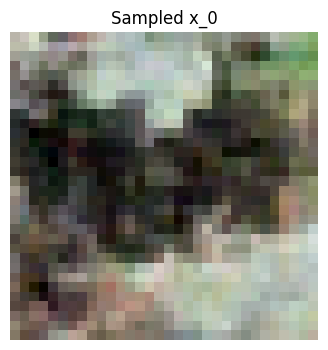

In [6]:
sample = pc_sampler(model, sde, shape=(64,3,32,32), device=device, n_steps_pc=3)
visualize_sample(sample.cpu().detach().numpy(), idx=0)

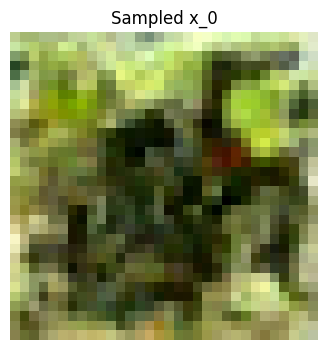

In [13]:
visualize_sample(sample.cpu().detach().numpy(), idx=5)